###**Variational Autoencoder <br>**

(Riya Arora)


---


In [3]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from PIL import Image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda





---


##### **Part A: Implement basic VAE on celebA faces dataset.**

In [6]:
import kagglehub

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

100%|██████████| 1.33G/1.33G [00:12<00:00, 115MB/s]

Extracting files...


In [7]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [8]:
!ls -R /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2 | head -n 30

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2:
img_align_celeba
list_attr_celeba.csv
list_bbox_celeba.csv
list_eval_partition.csv
list_landmarks_align_celeba.csv

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba:
img_align_celeba

/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba:
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg


In [ ]:
# !unzip '/content/drive/MyDrive/img_align_celeba.zip' -d '/content/sample_data/b21118-data-new/'

unzip:  cannot find or open /content/drive/MyDrive/img_align_celeba.zip, /content/drive/MyDrive/img_align_celeba.zip.zip or /content/drive/MyDrive/img_align_celeba.zip.ZIP.


In [ ]:
# !ls '/content/sample_data/b21118-data-new/img_align_celeba'

ls: cannot access '/content/sample_data/b21118-data-new/img_align_celeba': No such file or directory


In [9]:
output_dir = "/content/sample_data/b21118-results"
os.makedirs(output_dir, exist_ok=True)

In [10]:
# Data Hyperparameters
batch_size = 128
image_size = 64

In [11]:
# Data
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

data_dir = "/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Model Params
epochs = 10
latent_dim = 64
learning_rate = 1e-3

In [13]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # [64, 32, 32]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [128, 16, 16]
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),  # [256, 8, 8]
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),  # [512, 4, 4]
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.model(x).view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

In [14]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), 512, 4, 4)
        return self.model(x)

In [15]:
# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        z = mu + std * torch.randn_like(std)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(dataset):.4f}")

    # Sae sample images and checkpoints at every epoch
    model.eval()
    with torch.no_grad():
      sample = torch.randn(16, latent_dim).to(device)
      generated_images = model.decoder(sample)
      save_image(generated_images, os.path.join(output_dir, f"epoch_{epoch + 1}.png"), nrow=4)
      torch.save({'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict()}, "/content/sample_data/b21118-results/checkpoint.pth")

print("Training completed. Sample images saved to", output_dir)

Epoch 1/10, Loss: 723.3631
Epoch 2/10, Loss: 503.3926
Epoch 3/10, Loss: 487.7275
Epoch 4/10, Loss: 478.0193
Epoch 5/10, Loss: 470.1274
Epoch 6/10, Loss: 465.1953
Epoch 7/10, Loss: 461.6569
Epoch 8/10, Loss: 458.8574
Epoch 9/10, Loss: 456.4932
Epoch 10/10, Loss: 454.5943
Training completed. Sample images saved to /content/sample_data/b21118-results


In [ ]:
# Saving to drive as well
os.makedirs('/content/drive/MyDrive/gen-ai/vae-results', exist_ok=True)

!cp -r /content/sample_data/b21118-results /content/drive/MyDrive/gen-ai/vae-results

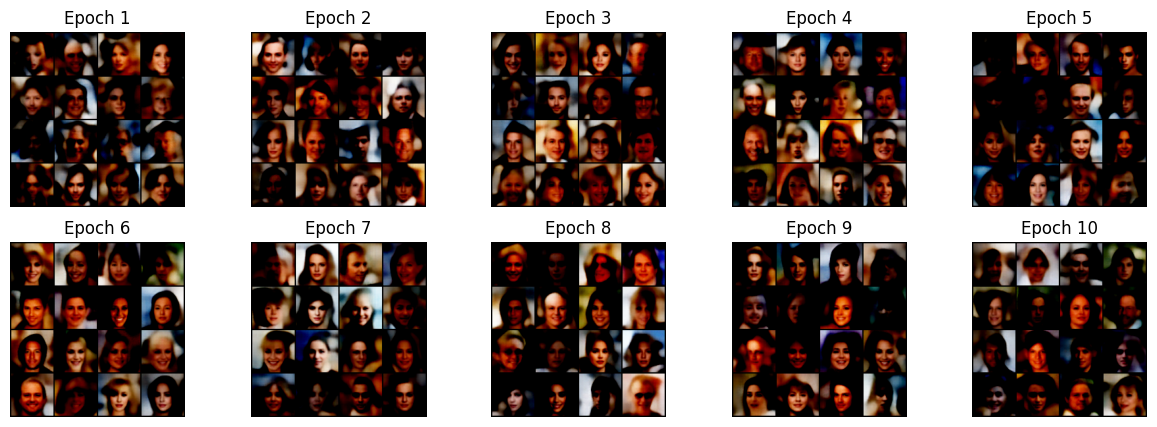

In [ ]:
# Epoch-wise Results
from PIL import Image

epoch_images = [f"epoch_{i+1}.png" for i in range(epochs)]

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, epoch_image in enumerate(epoch_images):
    image_path = os.path.join(output_dir, epoch_image)
    img = Image.open(image_path)

    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Epoch {i+1}")

plt.show()



---


##### **Part B: Latent Space arithmetic- Make your image smile.**

##### Modifying images in the original space first.

In [26]:
celeba_attr_df = pd.read_csv('/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv')

In [27]:
smiling_images = list(celeba_attr_df[celeba_attr_df['Smiling'] == 1].image_id)
non_smiling_images = list(celeba_attr_df[celeba_attr_df['Smiling'] == -1].image_id)
print(len(smiling_images))
print(len(non_smiling_images))
print((len(smiling_images) + len(non_smiling_images)) == len(celeba_attr_df))

97669
104930
True


In [36]:
outer_path = '/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba/'

In [ ]:
# Images shape

sample_image = celeba_attr_df.image_id[0]
complete_path = outer_path + sample_image
# Convert to array
img = Image.open(complete_path)
img_array = np.array(img, dtype=np.float64)
img_shape = img_array.shape

img_shape

(218, 178, 3)

In [ ]:
# Average of smiling and non-smiling images
smiling_sum = np.zeros((218, 178, 3), dtype=np.float64)
non_smiling_sum = np.zeros((218, 178, 3), dtype=np.float64)

for img in smiling_images:
    complete_path = outer_path + img
    # Convert to array
    img = Image.open(complete_path)
    img_array = np.array(img, dtype=np.float64)
    smiling_sum += img_array

for img in non_smiling_images:
    complete_path = outer_path + img
    # Convert to array
    img = Image.open(complete_path)
    img_array = np.array(img, dtype=np.float64)
    non_smiling_sum += img_array

smiling_avg = smiling_sum / len(smiling_images)
non_smiling_avg = non_smiling_sum / len(non_smiling_images)

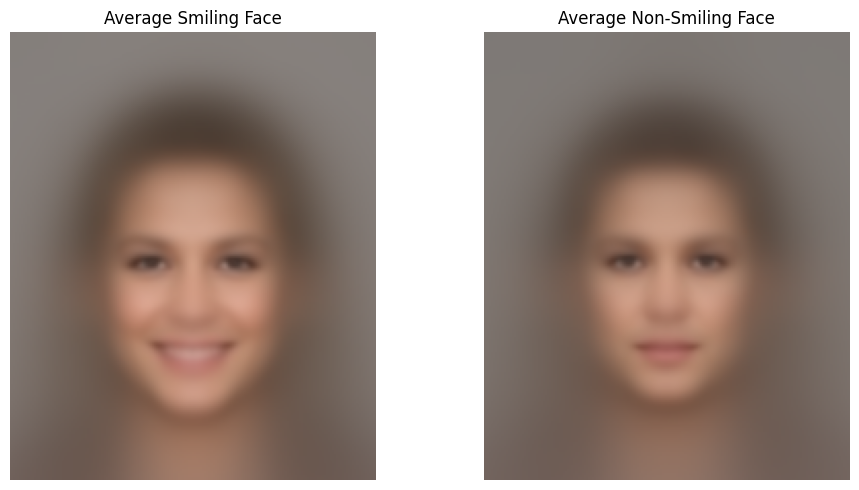

In [ ]:
# Plotting average smiling and non-smiling face

smiling_avg_uint8 = np.uint8(smiling_avg)
non_smiling_avg_uint8 = np.uint8(non_smiling_avg)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(smiling_avg_uint8)
plt.title("Average Smiling Face")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(non_smiling_avg_uint8)
plt.title("Average Non-Smiling Face")
plt.axis("off")

plt.tight_layout()
plt.show()

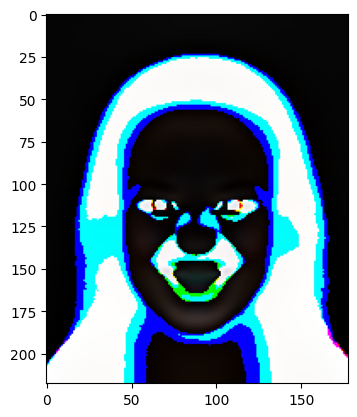

In [ ]:
# Smile Vector
smile_vector = smiling_avg - non_smiling_avg
smile_vector_uint8 = np.uint8(smile_vector)

plt.imshow(smile_vector_uint8)

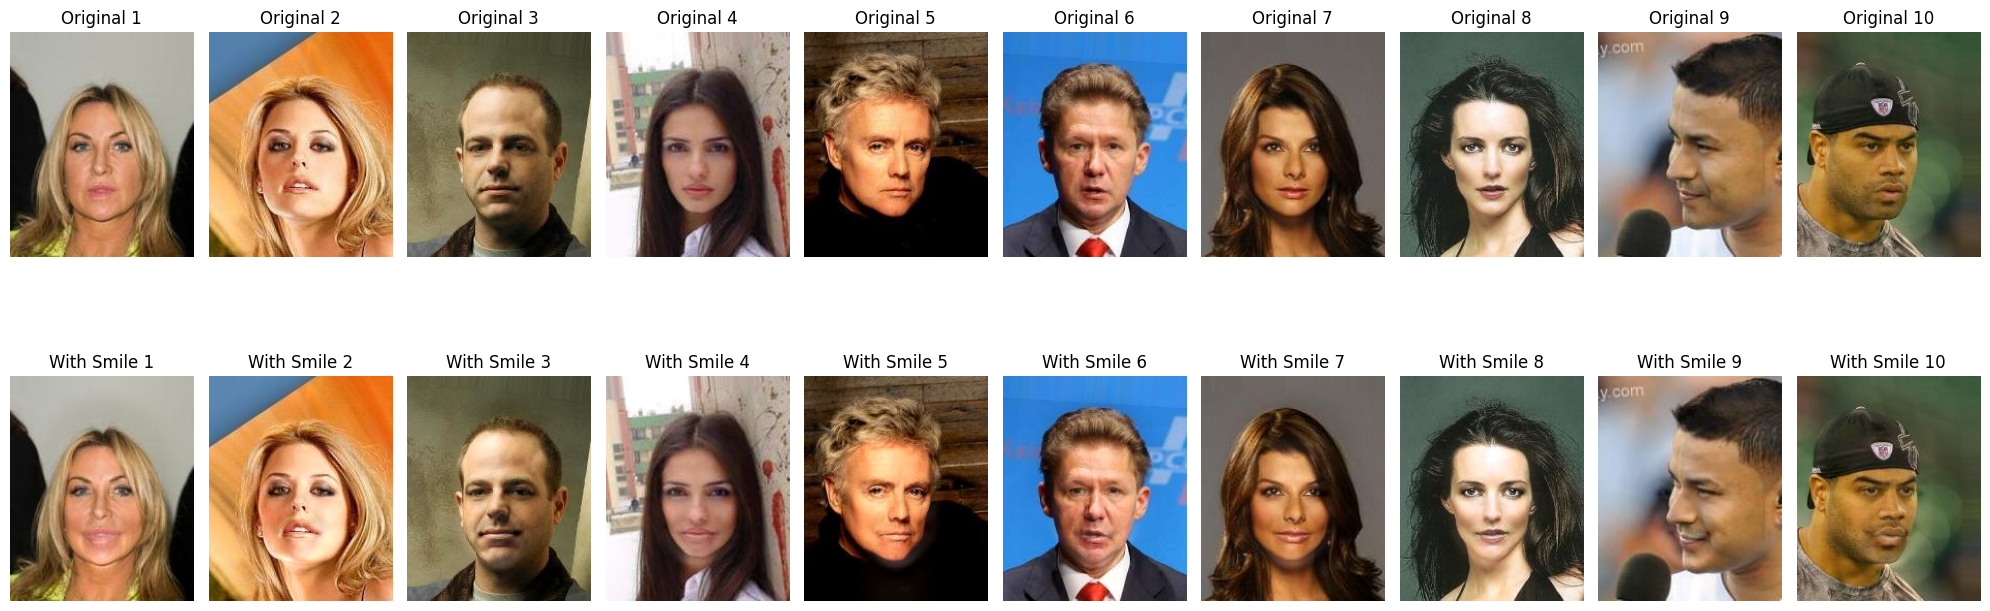

In [ ]:
# Adding smile to 10 non-smiling images

fig, axes = plt.subplots(2, 10, figsize=(20, 8))

for i, img_name in enumerate(non_smiling_images[10:20]):
    image_path = outer_path + img_name
    img = Image.open(image_path)
    img_array = np.array(img, dtype=np.float64)

    # Add the smile_vector
    modified_img_array = img_array + smile_vector

    modified_img_array = np.clip(modified_img_array, 0, 255).astype(np.uint8)

    # Plot original non-smiling image
    axes[0, i].imshow(img_array.astype(np.uint8))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    # Plot modified (smiling) image
    axes[1, i].imshow(modified_img_array)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"With Smile {i+1}")

plt.tight_layout()
plt.show()

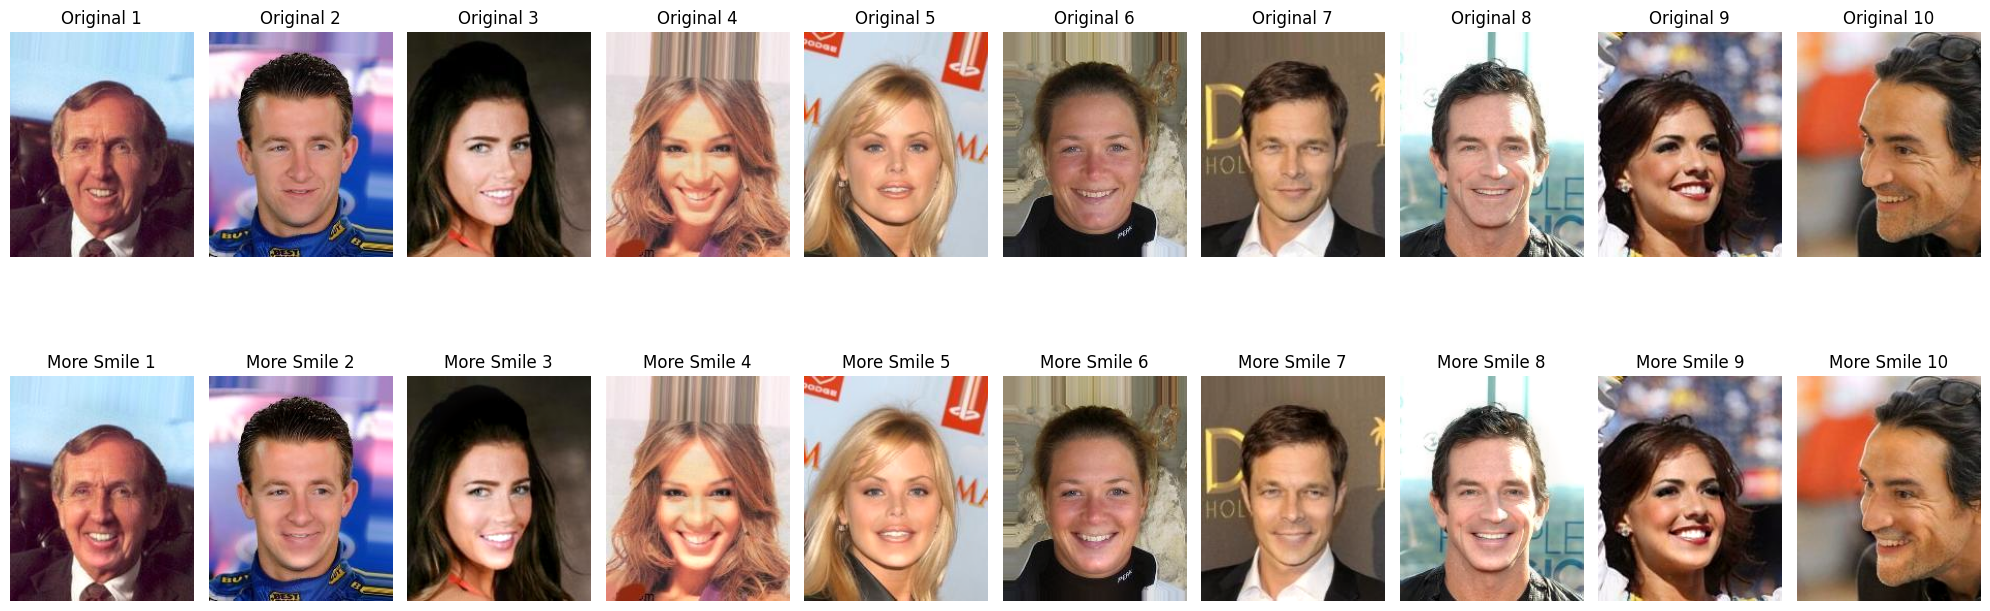

In [ ]:
# Making smiling images more-smiling

fig, axes = plt.subplots(2, 10, figsize=(20, 8))

for i, img_name in enumerate(smiling_images[10:20]):
    image_path = outer_path + img_name
    img = Image.open(image_path)
    img_array = np.array(img, dtype=np.float64)

    # Add the smile_vector
    modified_img_array = img_array + smile_vector

    modified_img_array = np.clip(modified_img_array, 0, 255).astype(np.uint8)

    # Plot original non-smiling image
    axes[0, i].imshow(img_array.astype(np.uint8))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    # Plot modified (smiling) image
    axes[1, i].imshow(modified_img_array)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"More Smile {i+1}")

plt.tight_layout()
plt.show()

##### Modifying images in the latent space finally.

In [ ]:
# Loading model from checkpoint

checkpoint_path = '/content/drive/MyDrive/gen-ai/checkpoint.pth'  # Adjust path accordingly
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [18]:
image_files = [f for f in os.listdir('/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba')]

latent_representations = []

for image_file in image_files:
    image_path = os.path.join('/root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba/img_align_celeba', image_file)
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get latent representation
    with torch.no_grad():
        mu, logvar = model.encoder(img_tensor)

    latent_representation = mu.cpu().numpy()
    latent_representations.append(latent_representation)

latent_representations = np.array(latent_representations)

In [19]:
np.save('/content/drive/MyDrive/gen-ai/latent_representations.npy', latent_representations)

In [25]:
latent_representations[0]

array([[-0.00907437,  0.0048206 , -0.00884007, -0.0043851 , -0.0028754 ,
         0.008177  ,  0.00932734, -0.0137432 ,  0.00413684,  0.00105587,
         0.02619513,  0.01599782, -0.0140968 , -0.00599224,  0.00329219,
        -0.00973685, -0.0010599 , -0.01073976, -0.0139031 ,  0.00273474,
        -0.01773481, -0.00112934,  0.0185953 ,  0.00332305,  0.02206302,
        -0.01130074, -0.00156989, -0.01350441,  0.01003142,  0.02402026,
         0.00556171,  0.00808423, -0.00230204, -0.0160646 , -0.01237095,
         0.01210685,  0.00371704,  0.01189852,  0.00778779, -0.00556173,
         0.00559254, -0.0020372 ,  0.00369425, -0.00377965,  0.01835706,
         0.0109705 , -0.00243647, -0.00134015,  0.00257333, -0.02896178,
        -0.00728243,  0.0031401 , -0.00821544,  0.00282792,  0.02307808,
         0.01610272,  0.0019961 ,  0.00058284,  0.01475377, -0.00425896,
        -0.00463836, -0.00948597, -0.00222425, -0.01075937]],
      dtype=float32)

In [32]:
smiling_latent_sum = np.zeros_like(latent_representations[0])
non_smiling_latent_sum = np.zeros_like(latent_representations[0])

for i in range(len(latent_representations)):
  if celeba_attr_df.loc[i, 'Smiling'] == 1:
    smiling_latent_sum += latent_representations[i]
  else:
    non_smiling_latent_sum += latent_representations[i]

smiling_latent_sum

array([[-1265.8213  ,   829.4585  ,  -453.90164 ,  -119.48286 ,
         -336.436   ,   867.72266 ,   412.52646 , -1096.853   ,
          175.01889 ,  -268.36383 ,  2071.7686  ,  1942.9407  ,
         -982.1368  ,  -158.94255 ,   515.94385 , -1208.9222  ,
         -168.76894 ,  -566.60144 , -1547.5465  ,   443.82593 ,
        -1115.425   ,  -404.00662 ,  2238.1343  ,   244.66039 ,
         1694.1816  ,  -273.6832  ,   260.21503 , -1386.8452  ,
          741.8525  ,  1950.9431  ,     8.851886,   681.133   ,
          131.16025 , -1628.702   , -1099.8337  ,  1090.6931  ,
          174.90036 ,   557.1985  ,   463.63724 ,  -396.21274 ,
         1207.4097  ,  -145.70387 ,   238.80917 ,   -27.61502 ,
         1732.5382  ,   534.2633  ,  -565.6074  ,  -161.89691 ,
         -475.2604  , -2354.138   ,  -929.8177  ,   720.3553  ,
         -912.9746  ,    74.88255 ,  1273.1699  ,  1062.6531  ,
           50.72839 ,   211.21774 ,  1119.6838  ,  -150.24475 ,
          276.1063  ,  -879.2101  ,  -32

In [34]:
smiling_latent_avg = smiling_latent_sum/len(smiling_images)
non_smiling_latent_avg = non_smiling_latent_sum/len(non_smiling_images)

smile_latent = smiling_latent_avg - non_smiling_latent_avg
smile_latent

array([[-2.35800347e-05,  7.91436876e-06, -7.85023738e-06,
        -3.10302192e-06, -2.01819137e-05,  1.29022737e-05,
        -1.80761252e-05, -3.79308409e-06,  1.02129441e-05,
         1.59353451e-06,  7.70709995e-06, -9.38531470e-06,
        -1.29455295e-05, -6.61831569e-06,  1.39651277e-05,
        -2.23509494e-05, -2.33239502e-05, -9.72977884e-06,
        -7.52293919e-06, -1.02907912e-05,  6.24524962e-07,
        -1.78900282e-05, -9.99870196e-07,  6.70529969e-06,
        -8.05974504e-06, -5.01352118e-06, -1.46521525e-05,
         1.61266515e-05,  9.95478948e-06,  5.39344750e-06,
         4.03688831e-05,  7.53701571e-08,  2.07393154e-05,
         5.98341984e-06,  7.03153169e-06, -1.11204729e-05,
        -6.66908117e-06, -5.14953925e-06,  5.59670790e-06,
         1.64597533e-05,  1.40723377e-05, -2.94251124e-05,
         2.27309435e-06, -1.23746200e-05, -1.31368211e-05,
         1.09059443e-05,  4.17908743e-06, -1.36158154e-06,
        -1.16963974e-05,  7.38173049e-06, -2.10375212e-0